<a href="https://colab.research.google.com/github/m-zayed5722/Miscellaneous-Projects/blob/main/Injection_Molding_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
normal_path = "/content/drive/My Drive/Colab Notebooks/datasets/SWaT_Dataset_Normal_v0.xlsx"
attack_path = "/content/drive/My Drive/Colab Notebooks/datasets/SWaT_Dataset_Attack_v0.xlsx"


In [ ]:
import pandas as pd

# Load the datasets
normal_df = pd.read_excel(normal_path)
attack_df = pd.read_excel(attack_path)

# Quick check
print("Normal shape:", normal_df.shape)
print("Attack shape:", attack_df.shape)

print("\nNormal dataset head:")
print(normal_df.head())

print("\nAttack dataset head:")
print(attack_df.head())


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Normal shape: (496801, 53)
Attack shape: (449920, 53)

Normal dataset head:
               Unnamed: 0        P1 Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0               Timestamp    FIT101     LIT101      MV101       P101   
1   22/12/2015 4:00:00 PM  2.470294   261.5804          2          2   
2   22/12/2015 4:00:01 PM  2.457163   261.1879          2          2   
3   22/12/2015 4:00:02 PM  2.439548   260.9131          2          2   
4   22/12/2015 4:00:03 PM  2.428338    260.285          2          2   

  Unnamed: 5        P2 Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 43  \
0       P102    AIT201     AIT202     AIT203     FIT201  ...        P501   
1          1  244.3284    8.19008    306.101   2.471278  ...           1   
2          1  244.3284    8.19008    306.101   2.468587  ...           1   
3          1  244.3284    8.19008    306.101   2.467305  ...           1   
4          1  244.3284    8.19008    306.101   2.466536  ...           1   

  Unnamed: 44 Unnamed: 45 Unnamed:

In [ ]:
# Define save paths (same folder as original Excel files)
normal_csv_path = "/content/drive/My Drive/Colab Notebooks/datasets/SWaT_Dataset_Normal_v0_new.csv"
attack_csv_path = "/content/drive/My Drive/Colab Notebooks/datasets/SWaT_Dataset_Attack_v0_new.csv"

# Save as CSV (much faster to load later)
normal_df.to_csv(normal_csv_path, index=False)
attack_df.to_csv(attack_csv_path, index=False)

print("CSV files saved to:", normal_csv_path, "and", attack_csv_path)


CSV files saved to: /content/drive/My Drive/Colab Notebooks/datasets/SWaT_Dataset_Normal_v0_new.csv and /content/drive/My Drive/Colab Notebooks/datasets/SWaT_Dataset_Attack_v0_new.csv


In [ ]:
###################################################################################################
###################################################################################################
# start here

# Load datasets (use CSV if you already converted, else use Excel)
normal_path = "/content/drive/My Drive/Colab Notebooks/datasets/SWaT_Dataset_Normal_v0_new.csv"
attack_path = "/content/drive/My Drive/Colab Notebooks/datasets/SWaT_Dataset_Attack_v0_new.csv"

attack_df = pd.read_csv(attack_path, header=1)
normal_df = pd.read_csv(normal_path, header=1)

# Strip whitespace from column names
normal_df.columns = normal_df.columns.str.strip()
attack_df.columns = attack_df.columns.str.strip()

# Now drop irrelevant columns
X_train = normal_df.drop(columns=["Timestamp", "Normal/Attack"])
X_test  = attack_df.drop(columns=["Timestamp", "Normal/Attack"])

# Clean labels
y_test = attack_df["Normal/Attack"].str.strip().replace({"A ttack": "Attack"})
y_test = y_test.replace({"Normal": 0, "Attack": 1})


/tmp/ipython-input-648476884.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = y_test.replace({"Normal": 0, "Attack": 1})


Best contamination: 0.007 with F1 score: 0.7384


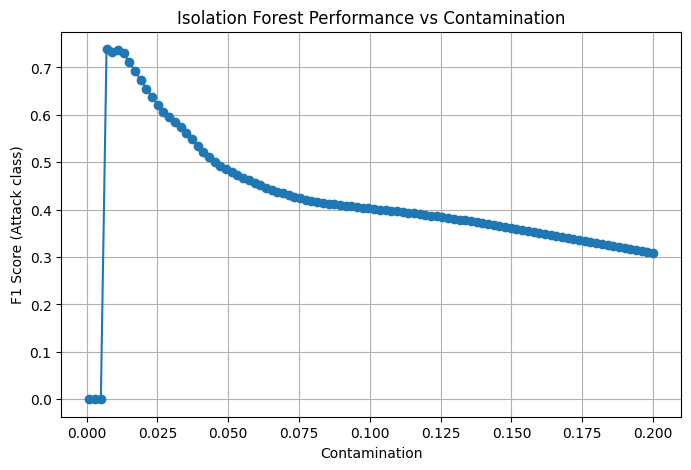

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# Range of contamination values (0.5% → 20%, 40 steps)
contaminations = np.linspace(0.001, 0.20, 100)

scores = []
best_score = 0
best_contamination = None

for c in contaminations:
    iso = IsolationForest(contamination=c, random_state=42)
    iso.fit(X_train)

    preds = iso.predict(X_test)
    preds = np.where(preds == 1, 0, 1)  # convert: -1 → 1 (attack), 1 → 0 (normal)

    score = f1_score(y_test, preds)
    scores.append(score)

    if score > best_score:
        best_score = score
        best_contamination = c

print(f"Best contamination: {best_contamination:.3f} with F1 score: {best_score:.4f}")

# --- Plot results ---
plt.figure(figsize=(8,5))
plt.plot(contaminations, scores, marker='o')
plt.xlabel("Contamination")
plt.ylabel("F1 Score (Attack class)")
plt.title("Isolation Forest Performance vs Contamination")
plt.grid(True)
plt.show()


In [ ]:
iso = IsolationForest(contamination=best_contamination, random_state=42)
iso.fit(X_train)
y_pred = iso.predict(X_test)
y_pred = np.where(y_pred == 1, 0, 1)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[395199     99]
 [ 22596  32025]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    395298
           1       1.00      0.59      0.74     54621

    accuracy                           0.95    449919
   macro avg       0.97      0.79      0.86    449919
weighted avg       0.95      0.95      0.94    449919

